In [1]:
import numpy as np
import cv2
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.models import model_from_json
import matplotlib.pyplot as plt
from os import listdir

Using TensorFlow backend.


In [3]:
import scipy.io
mat = scipy.io.loadmat('/Users/Aveen Faheem/Desktop/Anaconda_work/wiki_crop/wiki_crop/wiki.mat')
#Extracting wiki_crop.tar creates 100 folders and an index file (wiki.mat). 
#The index file is saved as Matlab format. We can read Matlab files in python with SciPy.

In [4]:
instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
import pandas as pd
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
for j in range(len(current_array)):
    df[columns[j]] = pd.DataFrame(current_array[j][0])


In [5]:
from datetime import datetime, timedelta
def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
 
    return exact_date.year
 
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [6]:
df['age'] = df['photo_taken'] - df['date_of_birth']

In [7]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]
 
#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]
 
#check threshold
df = df[df['face_score'] >= 3]
 
#some records do not have a gender information
df = df[~df['gender'].isna()]
 
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])


In [8]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

print (df)

          dob  photo_taken                          full_path  gender  age
0      723671         2009  [17/10000217_1981-05-05_2009.jpg]     1.0   28
2      711677         2008    [12/100012_1948-07-03_2008.jpg]     1.0   60
4      720044         2012  [16/10002116_1971-05-31_2012.jpg]     0.0   41
5      716189         2012  [02/10002702_1960-11-09_2012.jpg]     0.0   52
6      707745         1971  [41/10003541_1937-09-27_1971.jpg]     1.0   34
10     697114         1950  [99/10004299_1908-08-19_1950.jpg]     1.0   42
11     706177         1969   [56/1000456_1933-06-12_1969.jpg]     1.0   36
12     725873         2010  [82/10004882_1987-05-16_2010.jpg]     1.0   23
15     723643         2006  [47/10005947_1981-04-07_2006.jpg]     0.0   25
17     720853         2010  [50/10006850_1973-08-17_2010.jpg]     1.0   37
19     705106         2008   [81/1000781_1930-07-07_2008.jpg]     1.0   78
21     718880         2010    [97/100097_1968-03-23_2010.jpg]     1.0   42
23     723576         201

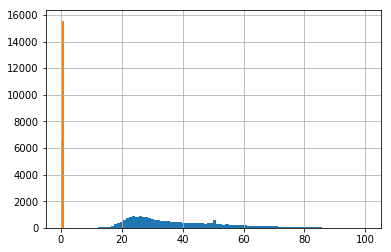

In [9]:
histogram_age = df['age'].hist(bins=df['age'].nunique())
histogram_gender = df['gender'].hist(bins=df['gender'].nunique())

In [10]:
target_size = (224, 224)
 
def getImagePixels(image_path):
    img = image.load_img("/Users/Aveen Faheem/Desktop/Anaconda_work/wiki_crop/wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x
 
df['pixels'] = df['full_path'].apply(getImagePixels)


KeyboardInterrupt: 

In [ ]:
#Apparent age prediction model

classes = 101 #0 to 100
target = df['age'].values
target_classes = keras.utils.to_categorical(target, classes)
 
features = []
 
for i in range(0, df.shape[0]):
features.append(df['pixels'].values[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)


In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.30)